Goal: Train and test a Linear Regression model using features: Bednights, Region, HHSize, HHEmployed, HHTANF, and slotted along with group: FamilyID to be able to predict bednights. Evaluate and iterate model.

In [1]:
##Load Modules for Regression Analysis training and testing
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn import set_config
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt

In [2]:
##Load Data, first inspection, create dummies for RegionCode
reg1 = pd.read_csv("C:/Users/morel/Downloads/Training Data 7-28-2025.csv")
reg1_dummies = pd.get_dummies(reg1, columns=['RegionCode','Destination','HHSize'], dtype=int)
print(reg1_dummies.head(5))

   FamilyID  ResidentID  Bednights  HHEmployed  HHTANF  Slotted  SlottedCCM  \
0       243         957        957           1       0        0           0   
1       243         958        957           1       0        0           0   
2       243         959        957           1       0        0           0   
3       243         960        957           1       0        0           0   
4       242         973        944           1       0        1           1   

   SlottedPME  SingleMom  SingleDad  ...  Destination_10  Destination_11  \
0           0          1          0  ...               0               0   
1           0          1          0  ...               0               0   
2           0          1          0  ...               0               0   
3           0          1          0  ...               0               0   
4           0          0          0  ...               0               0   

   HHSize_2  HHSize_3  HHSize_4  HHSize_5  HHSize_6  HHSize_7  HHSiz

In [3]:
##EDA: no missing expected. No duplicates expected.
reg1_dummies.isna().sum()

FamilyID          0
ResidentID        0
Bednights         0
HHEmployed        0
HHTANF            0
Slotted           0
SlottedCCM        0
SlottedPME        0
SingleMom         0
SingleDad         0
SingleParent      0
Disability        0
RegionCode_1      0
RegionCode_2      0
RegionCode_3      0
RegionCode_4      0
RegionCode_5      0
Destination_1     0
Destination_2     0
Destination_3     0
Destination_4     0
Destination_5     0
Destination_6     0
Destination_7     0
Destination_8     0
Destination_9     0
Destination_10    0
Destination_11    0
HHSize_2          0
HHSize_3          0
HHSize_4          0
HHSize_5          0
HHSize_6          0
HHSize_7          0
HHSize_8          0
HHSize_9          0
dtype: int64

In [4]:
reg1_dummies.duplicated().any()

False

In [5]:
##EDA: descriptive stattistics.
##FamilyID and ResidentID aren't interpretable.
##Each individual stayed at the facility for an average of 500 nights, for a median of 399. 50% of people stayed for 399 nights,
##some people stayed for many fewer nights, a minimum of 80 nights, skewing the average low. The standard deviation is also high.
##Regioncode is categorical. However, 50% of people are from region 1.
##50% of families have 4 people. On average, each family has 4.5 members.
##HHEmployed is categorical (yes/no). However, over 50% of households have at least one employed adult. This is supported by the average,
##showing 70% of households have at least one employed adult.
##HHTANF is categorical (yes,no). However, 50% of households have no members that receive TANF. This is supported by the average,
##showing that 40% of households have a member (or more) recieving TANF.
##Slotted is categorical (yes/no). However, 50% of families were slotted before they moved out. This is supported by the average,
##showing that about 60% of families were slotted before they move out.
reg1_dummies.describe()

,FamilyID,ResidentID,Bednights,HHEmployed,HHTANF,Slotted,SlottedCCM,SlottedPME,SingleMom,SingleDad,...,Destination_10,Destination_11,HHSize_2,HHSize_3,HHSize_4,HHSize_5,HHSize_6,HHSize_7,HHSize_8,HHSize_9
count,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,...,241.000000,241.000000,241.000000,241.000000,241.00000,241.000000,241.000000,241.000000,241.000000,241.000000
mean,459.344398,1758.165975,530.497925,0.726141,0.435685,0.680498,0.427386,0.253112,0.311203,0.062241,...,0.008299,0.219917,0.062241,0.248963,0.26556,0.195021,0.128631,0.029046,0.033195,0.037344
std,140.954579,467.250109,310.345548,0.446866,0.496878,0.467254,0.495729,0.435699,0.463949,0.242095,...,0.090908,0.415052,0.242095,0.433312,0.44255,0.397041,0.335488,0.168284,0.179518,0.189999
min,223.000000,957.000000,80.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,281.000000,1200.000000,282.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,531.000000,2028.000000,448.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,574.000000,2110.000000,877.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000
max,596.000000,2210.000000,1078.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
##Regression analysis: predicto move out date - prepare data
x = reg1_dummies.drop(columns=['Bednights','FamilyID','ResidentID']) ##features doesn't include target values: bednights, or FamilyID (not a feature)
y = reg1_dummies['Bednights']                                        ##target values
groups = reg1_dummies['FamilyID']                                    ##groupding varible for GroupKFOld to mitigate autocorrelation, keeps all members of the 
                                                             ##same family together to not make the model seem better than it actually is

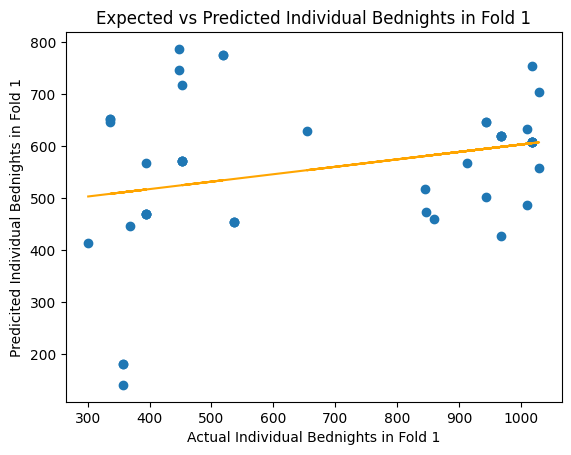

Fold 1 - MSE: 90774.3987, RMSE: 301.2879, R^2: -0.16585271752805553


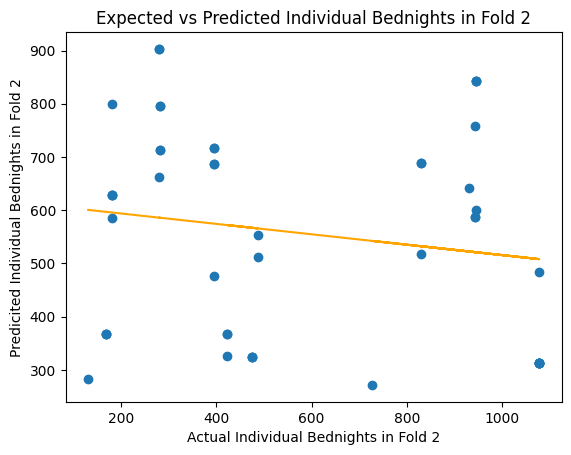

Fold 2 - MSE: 173270.1761, RMSE: 416.2573, R^2: -0.5343579701904573


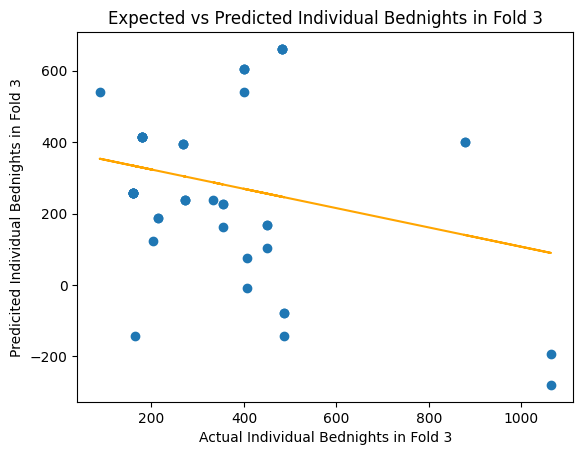

Fold 3 - MSE: 136392.0133, RMSE: 369.3129, R^2: -1.762519186888087


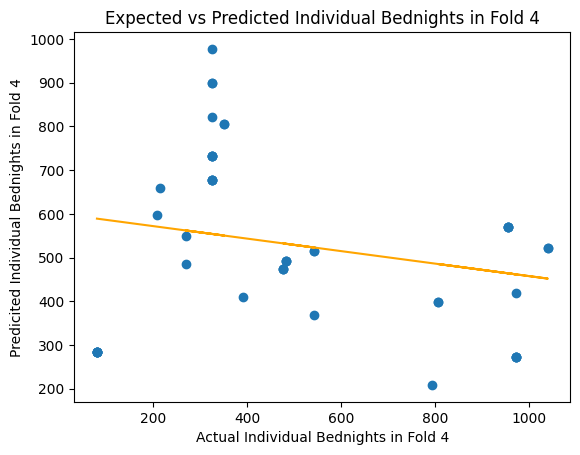

Fold 4 - MSE: 161128.3211, RMSE: 401.4079, R^2: -0.6912939300894161


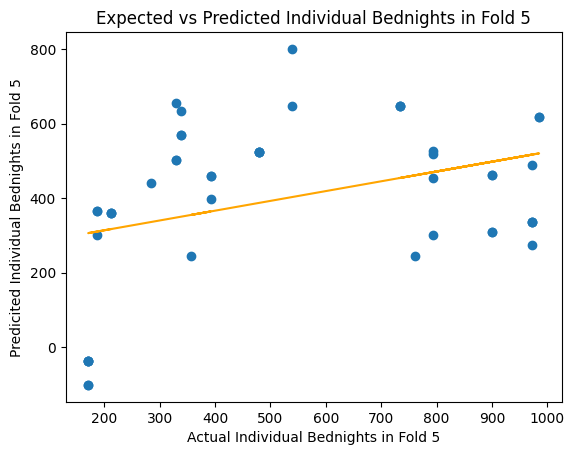

Fold 5 - MSE: 105170.9240, RMSE: 324.3007, R^2: -0.19752393294793458


<Figure size 640x480 with 0 Axes>

In [11]:
##Regression Analysis: predict move out date
##create folds
gkf = GroupKFold(n_splits = 5)

##split the data in each fold
for fold, (train_idx, test_idx) in enumerate(gkf.split(x, y, groups)):
    x_train, x_test = x.iloc[train_idx], x.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    ##scale target feature
    y_scaler = RobustScaler()
    y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1,1)).ravel()

    ##train a model and predict target values for each fold
    model = LinearRegression()
    model.fit(x_train, y_train_scaled)
    y_pred_scaled = model.predict(x_test)
    y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1,1))

    ##compare predicted values and expected values for each model
    plt.scatter(y_test, y_pred)
    plt.xlabel(f'Actual Individual Bednights in Fold {fold+1}')
    plt.ylabel(f'Predicited Individual Bednights in Fold {fold+1}')
    plt.title(f'Expected vs Predicted Individual Bednights in Fold {fold+1}')
    a, b = np.polyfit(y_test, y_pred, 1)
    plt.plot(y_test, a*(y_test)+b, color='orange')
    plt.show()
    plt.clf()

    ##Evaluate. The higher the mse & rmse, the worse the model. The lower and more negative the R^2 the worse the model
    ##the models are very bad. they are equally bad from the stable RMSEs and the similar R^2s.
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f'Fold {fold+1} - MSE: {mse:.4f}, RMSE: {rmse:.4f}, R^2: {r2}')

Goal: Improve the model. Standardizing the target feature worsened the model. Opening a new notebook to try SFS with standardization so that I don't ruin the work I've done below.

In [12]:
##Sequential feature selection to build the best model by adding onw feature at a time
##HHSize and HHEmployed are the features that best predict bednights.
set_config(enable_metadata_routing=True)
sfs = SequentialFeatureSelector(LinearRegression(), direction='forward', scoring='r2', cv=gkf)
sfs.fit(x, y, groups=groups)
print(x.columns[sfs.get_support()])

Index(['HHEmployed', 'SlottedPME', 'SingleMom', 'SingleDad', 'SingleParent',
       'Disability', 'RegionCode_3', 'RegionCode_4', 'RegionCode_5',
       'Destination_2', 'Destination_4', 'Destination_10', 'HHSize_4',
       'HHSize_7', 'HHSize_8', 'HHSize_9'],
      dtype='object')


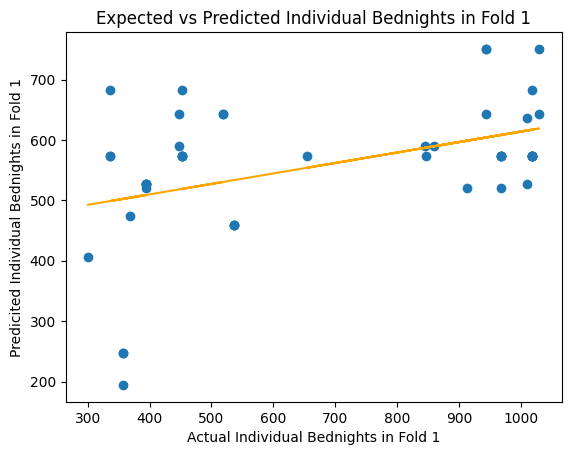

Fold 1 - MSE: 78674.6734, RMSE: 280.4901, R^2: -0.010450998200913553


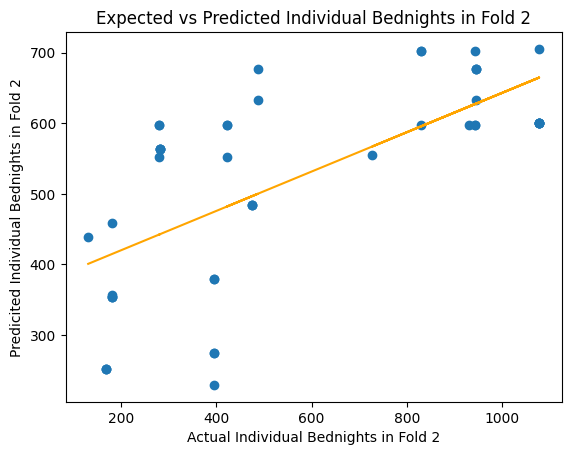

Fold 2 - MSE: 71856.5385, RMSE: 268.0607, R^2: 0.36368938357994396


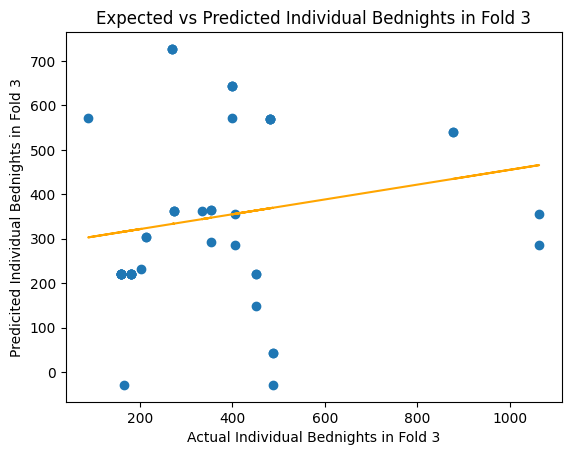

Fold 3 - MSE: 71343.8840, RMSE: 267.1028, R^2: -0.4450175169719248


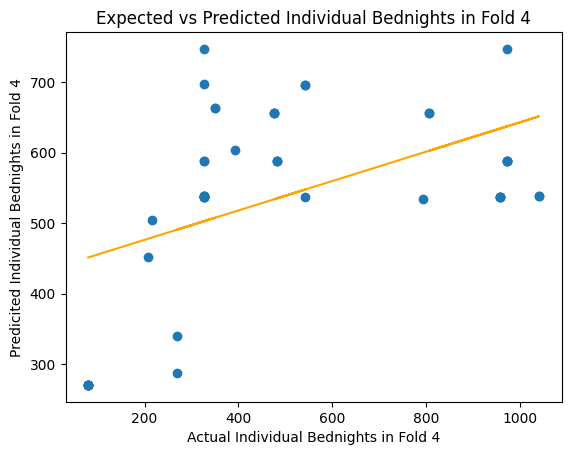

Fold 4 - MSE: 74234.2060, RMSE: 272.4595, R^2: 0.2207958155283224


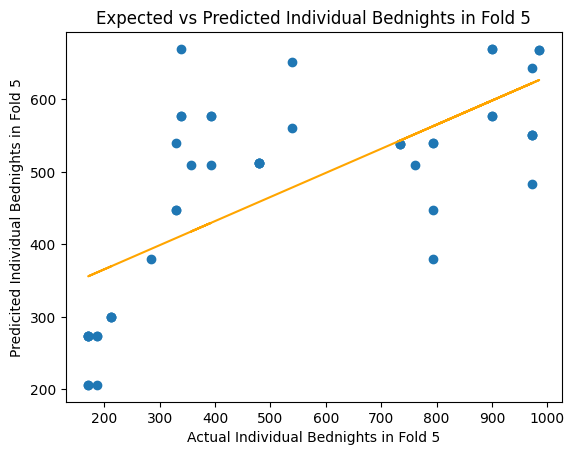

Fold 5 - MSE: 52247.3484, RMSE: 228.5768, R^2: 0.40508794891713784


<Figure size 640x480 with 0 Axes>

In [13]:
##Review new model using SFS features: new dummy added for this attempt
x2 = reg1_dummies[['HHEmployed', 'SlottedPME', 'SingleMom', 'SingleDad', 'SingleParent',
       'Disability', 'RegionCode_3', 'RegionCode_4', 'RegionCode_5',
       'Destination_2', 'Destination_4', 'Destination_10', 'HHSize_4',
       'HHSize_7', 'HHSize_8', 'HHSize_9']]
y2 = reg1_dummies['Bednights']                           
groups2 = reg1_dummies['FamilyID']

gkf = GroupKFold(n_splits = 5)

##split the data in each fold
for fold, (train_idx, test_idx) in enumerate(gkf.split(x2, y2, groups2)):
    x_train, x_test = x2.iloc[train_idx], x2.iloc[test_idx]
    y_train, y_test = y2.iloc[train_idx], y2.iloc[test_idx]

    ##train a model and predict target values for each fold
    model2 = LinearRegression()
    model2.fit(x_train, y_train)
    y_pred = model2.predict(x_test)

    ##compare predicted values and expected values for each model
    plt.scatter(y_test, y_pred)
    plt.xlabel(f'Actual Individual Bednights in Fold {fold+1}')
    plt.ylabel(f'Predicited Individual Bednights in Fold {fold+1}')
    plt.title(f'Expected vs Predicted Individual Bednights in Fold {fold+1}')
    a, b = np.polyfit(y_test, y_pred, 1)
    plt.plot(y_test, a*(y_test)+b, color='orange')
    plt.show()
    plt.clf()

    ##Evaluate. The higher the mse & rmse, the worse the model. The lower and more negative the R^2 the worse the model
    ##the new models are very bad. they are equally bad from the stable RMSEs and the similar R^2s.
    set_config(enable_metadata_routing=False)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f'Fold {fold+1} - MSE: {mse:.4f}, RMSE: {rmse:.4f}, R^2: {r2}')

Outcome: Linear Regression model and Sequential Fit Selector used to try to improve model. Model remains neutral to very bad. Will attempt Random Forest Regression.